#  Store Item Demand Forecasting Challenge
### Goal - Predict 3 months of item sales at different stores

https://www.kaggle.com/c/demand-forecasting-kernels-only

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

This is a great competition to explore different models and improve your skills in forecasting.

In [0]:
import pandas as pd
import numpy as np
import random
import matplotlib
import os
import torch
# matplotlib.use('Agg')
%matplotlib inline

import datetime as dt, itertools, pandas as pd, matplotlib.pyplot as plt, numpy as np


In [0]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

## Load datasets

In [0]:
import os
os.chdir('C:/Users/sg050/Desktop/kaggle-demand-forecasting')

In [0]:
datadir='data'
train_df = pd.read_csv(f'{datadir}/train.csv', low_memory=False, parse_dates=['date'], dtype={'store': str, 'item': str})
subs = pd.read_csv(f'{datadir}/sample_submission.csv')

In [0]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [0]:
def transformDataset(data,train=True):
    data['store_item']= data['store']+'_'+data['item']
    data.drop(columns=['store', 'item'])
    mat=data.pivot(index='date',columns='store_item',values='sales')
    return mat

In [0]:
df_train = transformDataset(train_df)

In [0]:
df_train.shape

(1826, 500)

In [0]:
n_sampling=3200
n_seqlen=300
trainseq=[]
for idx in range(n_sampling):
    it=np.random.choice(500, 1, replace =True)[0]
    istr=np.random.choice(500, 1, replace =True)[0]
    tmpseq=df_train.iloc[it:(it+n_seqlen+90),istr].values
    trainseq.append(tmpseq)

In [0]:
trainseq_arr = np.array(trainseq) # shape : (n_sampling, n_seqlen)

In [0]:
X_train = trainseq_arr[:int(n_sampling*0.8),:n_seqlen]
print(X_train.shape) # shape : (n_sampling, n_seqlen)

(2560, 300)


In [0]:
y_train =trainseq_arr[:int(n_sampling*0.8),n_seqlen:]
print(y_train.shape) # shape :( n_sampling ,90 )

(2560, 90)


In [0]:
X_val =trainseq_arr[int(n_sampling*0.8):,:n_seqlen]
y_val =trainseq_arr[int(n_sampling*0.8):,n_seqlen:]

### keras

In [0]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
import keras
import tensorflow as tf

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [0]:
input_size = 300
# hidden_size = 100
output_size = 90
batch_size = 128

model_LSTM = Sequential()
model_LSTM.add(LSTM(input_size, batch_input_shape=(batch_size, input_size,1))) # input_shape=(maxlen, input_size)
model_LSTM.add(Dense(output_size, activation="linear"))
model_LSTM.compile(loss='mse', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (128, 300)                362400    
_________________________________________________________________
dense_1 (Dense)              (128, 90)                 27090     
Total params: 389,490
Trainable params: 389,490
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train_reshape=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
X_val_reshape=np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [0]:
tb = keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=0, write_graph=True, write_images=True)

In [0]:
%%time
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model_LSTM.fit(X_train_reshape, y_train, epochs=500,
               validation_data=(X_val_reshape, y_val),
          batch_size=batch_size, verbose=1, callbacks=[early_stop,tb], use_multiprocessing= True)

Instructions for updating:
Use tf.cast instead.
Train on 2560 samples, validate on 640 samples
Epoch 1/500
2560/2560 [==============================] - ETA: 44s - loss: 3049.197 - ETA: 29s - loss: 3009.962 - ETA: 23s - loss: 2912.494 - ETA: 20s - loss: 3019.100 - ETA: 18s - loss: 3036.218 - ETA: 16s - loss: 3076.408 - ETA: 14s - loss: 3018.610 - ETA: 13s - loss: 2967.596 - ETA: 11s - loss: 2968.202 - ETA: 10s - loss: 2918.501 - ETA: 9s - loss: 2914.801 - ETA: 8s - loss: 2910.07 - ETA: 7s - loss: 2909.67 - ETA: 6s - loss: 2892.85 - ETA: 5s - loss: 2861.38 - ETA: 4s - loss: 2856.10 - ETA: 3s - loss: 2845.53 - ETA: 2s - loss: 2820.83 - ETA: 1s - loss: 2799.59 - 23s 9ms/step - loss: 2790.2568 - val_loss: 2738.2580
Epoch 2/500
2560/2560 [==============================] - ETA: 19s - loss: 2263.708 - ETA: 17s - loss: 2234.136 - ETA: 15s - loss: 2332.876 - ETA: 14s - loss: 2368.492 - ETA: 13s - loss: 2349.571 - ETA: 12s - loss: 2386.424 - ETA: 11s - loss: 2363.920 - ETA: 10s - loss: 2325.129 -

2560/2560 [==============================] - ETA: 19s - loss: 725.21 - ETA: 17s - loss: 672.51 - ETA: 16s - loss: 680.93 - ETA: 15s - loss: 669.76 - ETA: 13s - loss: 659.29 - ETA: 12s - loss: 651.84 - ETA: 11s - loss: 665.22 - ETA: 11s - loss: 672.76 - ETA: 10s - loss: 671.21 - ETA: 9s - loss: 663.4741 - ETA: 8s - loss: 677.615 - ETA: 7s - loss: 682.112 - ETA: 6s - loss: 678.143 - ETA: 5s - loss: 689.451 - ETA: 4s - loss: 690.646 - ETA: 3s - loss: 690.212 - ETA: 2s - loss: 688.561 - ETA: 1s - loss: 688.266 - ETA: 0s - loss: 698.820 - 21s 8ms/step - loss: 699.2893 - val_loss: 755.9950
Epoch 14/500
2560/2560 [==============================] - ETA: 19s - loss: 752.60 - ETA: 17s - loss: 708.32 - ETA: 16s - loss: 736.45 - ETA: 14s - loss: 747.77 - ETA: 13s - loss: 741.53 - ETA: 12s - loss: 715.70 - ETA: 11s - loss: 725.22 - ETA: 11s - loss: 713.31 - ETA: 10s - loss: 702.28 - ETA: 9s - loss: 693.6396 - ETA: 8s - loss: 688.744 - ETA: 7s - loss: 689.348 - ETA: 6s - loss: 697.507 - ETA: 5s - lo

2560/2560 [==============================] - ETA: 18s - loss: 641.90 - ETA: 16s - loss: 610.41 - ETA: 15s - loss: 617.98 - ETA: 14s - loss: 634.97 - ETA: 13s - loss: 632.25 - ETA: 12s - loss: 654.66 - ETA: 12s - loss: 654.56 - ETA: 11s - loss: 649.95 - ETA: 10s - loss: 657.14 - ETA: 9s - loss: 674.9308 - ETA: 8s - loss: 686.831 - ETA: 7s - loss: 687.840 - ETA: 6s - loss: 689.128 - ETA: 5s - loss: 683.230 - ETA: 4s - loss: 679.460 - ETA: 3s - loss: 684.974 - ETA: 2s - loss: 678.944 - ETA: 1s - loss: 680.873 - ETA: 0s - loss: 675.626 - 21s 8ms/step - loss: 671.3629 - val_loss: 717.9862
Epoch 27/500
2560/2560 [==============================] - ETA: 20s - loss: 707.21 - ETA: 17s - loss: 687.48 - ETA: 16s - loss: 669.00 - ETA: 15s - loss: 665.54 - ETA: 14s - loss: 669.04 - ETA: 13s - loss: 672.53 - ETA: 12s - loss: 666.06 - ETA: 11s - loss: 659.68 - ETA: 10s - loss: 653.98 - ETA: 9s - loss: 668.2962 - ETA: 8s - loss: 664.155 - ETA: 7s - loss: 666.822 - ETA: 6s - loss: 664.868 - ETA: 5s - lo

2560/2560 [==============================] - ETA: 18s - loss: 679.51 - ETA: 17s - loss: 662.19 - ETA: 15s - loss: 644.50 - ETA: 14s - loss: 661.40 - ETA: 13s - loss: 665.24 - ETA: 12s - loss: 660.26 - ETA: 11s - loss: 667.69 - ETA: 11s - loss: 657.23 - ETA: 10s - loss: 664.02 - ETA: 9s - loss: 660.4958 - ETA: 8s - loss: 668.111 - ETA: 7s - loss: 670.374 - ETA: 6s - loss: 665.613 - ETA: 5s - loss: 661.623 - ETA: 4s - loss: 661.688 - ETA: 3s - loss: 659.426 - ETA: 2s - loss: 659.227 - ETA: 1s - loss: 658.775 - ETA: 0s - loss: 662.478 - 21s 8ms/step - loss: 657.3096 - val_loss: 703.2631
Epoch 40/500
2560/2560 [==============================] - ETA: 19s - loss: 634.17 - ETA: 17s - loss: 745.15 - ETA: 16s - loss: 699.62 - ETA: 15s - loss: 701.11 - ETA: 14s - loss: 674.94 - ETA: 13s - loss: 669.88 - ETA: 12s - loss: 655.51 - ETA: 11s - loss: 672.20 - ETA: 10s - loss: 665.22 - ETA: 9s - loss: 659.4918 - ETA: 8s - loss: 659.402 - ETA: 7s - loss: 656.092 - ETA: 6s - loss: 659.815 - ETA: 5s - lo

2560/2560 [==============================] - ETA: 20s - loss: 655.58 - ETA: 18s - loss: 607.01 - ETA: 16s - loss: 606.17 - ETA: 15s - loss: 630.15 - ETA: 13s - loss: 630.18 - ETA: 12s - loss: 615.78 - ETA: 11s - loss: 637.91 - ETA: 10s - loss: 639.71 - ETA: 10s - loss: 634.54 - ETA: 9s - loss: 626.4385 - ETA: 8s - loss: 625.105 - ETA: 7s - loss: 635.544 - ETA: 6s - loss: 634.073 - ETA: 5s - loss: 646.602 - ETA: 4s - loss: 652.996 - ETA: 3s - loss: 649.962 - ETA: 2s - loss: 644.047 - ETA: 1s - loss: 645.192 - ETA: 0s - loss: 644.059 - 21s 8ms/step - loss: 643.5066 - val_loss: 689.0432
Epoch 53/500
2560/2560 [==============================] - ETA: 22s - loss: 474.25 - ETA: 18s - loss: 551.73 - ETA: 16s - loss: 585.52 - ETA: 15s - loss: 659.20 - ETA: 14s - loss: 637.64 - ETA: 13s - loss: 625.00 - ETA: 12s - loss: 618.18 - ETA: 11s - loss: 614.63 - ETA: 10s - loss: 623.56 - ETA: 9s - loss: 625.9658 - ETA: 8s - loss: 619.566 - ETA: 7s - loss: 621.630 - ETA: 6s - loss: 626.953 - ETA: 5s - lo

2560/2560 [==============================] - ETA: 20s - loss: 640.81 - ETA: 18s - loss: 624.81 - ETA: 16s - loss: 625.34 - ETA: 15s - loss: 654.56 - ETA: 14s - loss: 636.84 - ETA: 13s - loss: 627.62 - ETA: 12s - loss: 613.75 - ETA: 11s - loss: 621.39 - ETA: 10s - loss: 617.00 - ETA: 9s - loss: 630.5491 - ETA: 8s - loss: 632.349 - ETA: 7s - loss: 641.151 - ETA: 6s - loss: 632.555 - ETA: 5s - loss: 632.063 - ETA: 4s - loss: 630.199 - ETA: 3s - loss: 631.583 - ETA: 2s - loss: 627.693 - ETA: 1s - loss: 630.937 - ETA: 0s - loss: 627.354 - 21s 8ms/step - loss: 625.1842 - val_loss: 656.5222
Epoch 66/500
2560/2560 [==============================] - ETA: 40s - loss: 485.81 - ETA: 54s - loss: 568.10 - ETA: 41s - loss: 609.34 - ETA: 34s - loss: 598.60 - ETA: 29s - loss: 620.75 - ETA: 25s - loss: 599.84 - ETA: 22s - loss: 608.51 - ETA: 4:46 - loss: 598.218 - ETA: 3:54 - loss: 605.962 - ETA: 3:12 - loss: 598.812 - ETA: 2:38 - loss: 595.537 - ETA: 2:09 - loss: 593.525 - ETA: 1:45 - loss: 589.567 - E

2560/2560 [==============================] - ETA: 19s - loss: 317.90 - ETA: 18s - loss: 287.63 - ETA: 16s - loss: 267.48 - ETA: 15s - loss: 271.86 - ETA: 14s - loss: 273.49 - ETA: 13s - loss: 288.91 - ETA: 12s - loss: 290.93 - ETA: 11s - loss: 303.58 - ETA: 10s - loss: 315.23 - ETA: 9s - loss: 312.6192 - ETA: 8s - loss: 314.786 - ETA: 7s - loss: 313.170 - ETA: 6s - loss: 309.601 - ETA: 5s - loss: 305.028 - ETA: 4s - loss: 302.811 - ETA: 3s - loss: 297.774 - ETA: 2s - loss: 297.028 - ETA: 1s - loss: 292.858 - ETA: 0s - loss: 290.565 - 21s 8ms/step - loss: 291.7954 - val_loss: 307.4240
Epoch 79/500
2560/2560 [==============================] - ETA: 21s - loss: 247.92 - ETA: 18s - loss: 242.61 - ETA: 16s - loss: 269.66 - ETA: 15s - loss: 260.56 - ETA: 14s - loss: 270.69 - ETA: 13s - loss: 271.58 - ETA: 12s - loss: 272.59 - ETA: 11s - loss: 270.16 - ETA: 10s - loss: 276.43 - ETA: 9s - loss: 271.9555 - ETA: 8s - loss: 264.253 - ETA: 7s - loss: 265.225 - ETA: 6s - loss: 264.735 - ETA: 5s - lo

2560/2560 [==============================] - ETA: 20s - loss: 157.15 - ETA: 17s - loss: 160.13 - ETA: 16s - loss: 158.91 - ETA: 15s - loss: 155.78 - ETA: 14s - loss: 154.24 - ETA: 13s - loss: 157.05 - ETA: 12s - loss: 158.87 - ETA: 11s - loss: 161.09 - ETA: 10s - loss: 159.92 - ETA: 9s - loss: 157.4900 - ETA: 8s - loss: 158.605 - ETA: 7s - loss: 157.689 - ETA: 6s - loss: 157.481 - ETA: 5s - loss: 158.693 - ETA: 4s - loss: 157.925 - ETA: 3s - loss: 157.450 - ETA: 2s - loss: 159.225 - ETA: 1s - loss: 158.032 - ETA: 0s - loss: 158.350 - 21s 8ms/step - loss: 158.9945 - val_loss: 175.8361
Epoch 92/500
2560/2560 [==============================] - ETA: 20s - loss: 149.91 - ETA: 17s - loss: 144.86 - ETA: 16s - loss: 141.35 - ETA: 14s - loss: 144.50 - ETA: 13s - loss: 149.13 - ETA: 12s - loss: 153.67 - ETA: 11s - loss: 154.00 - ETA: 10s - loss: 158.75 - ETA: 9s - loss: 155.1452 - ETA: 9s - loss: 156.954 - ETA: 8s - loss: 156.251 - ETA: 7s - loss: 155.117 - ETA: 6s - loss: 156.074 - ETA: 5s - lo

2560/2560 [==============================] - ETA: 18s - loss: 121.67 - ETA: 16s - loss: 127.14 - ETA: 15s - loss: 138.67 - ETA: 14s - loss: 146.63 - ETA: 13s - loss: 149.66 - ETA: 12s - loss: 148.35 - ETA: 11s - loss: 150.33 - ETA: 10s - loss: 148.43 - ETA: 9s - loss: 149.9479 - ETA: 8s - loss: 150.484 - ETA: 8s - loss: 148.175 - ETA: 7s - loss: 146.959 - ETA: 6s - loss: 147.346 - ETA: 5s - loss: 148.153 - ETA: 4s - loss: 148.388 - ETA: 3s - loss: 148.531 - ETA: 2s - loss: 149.188 - ETA: 1s - loss: 149.255 - ETA: 0s - loss: 149.930 - 21s 8ms/step - loss: 150.3894 - val_loss: 161.5743
Epoch 105/500
2560/2560 [==============================] - ETA: 19s - loss: 151.65 - ETA: 17s - loss: 151.51 - ETA: 15s - loss: 144.29 - ETA: 14s - loss: 141.77 - ETA: 13s - loss: 142.99 - ETA: 12s - loss: 146.00 - ETA: 11s - loss: 145.71 - ETA: 11s - loss: 149.10 - ETA: 10s - loss: 147.78 - ETA: 9s - loss: 146.1601 - ETA: 8s - loss: 146.064 - ETA: 7s - loss: 146.190 - ETA: 6s - loss: 145.896 - ETA: 5s - l

2560/2560 [==============================] - ETA: 20s - loss: 142.98 - ETA: 17s - loss: 132.32 - ETA: 16s - loss: 126.36 - ETA: 15s - loss: 121.68 - ETA: 13s - loss: 120.39 - ETA: 12s - loss: 123.19 - ETA: 12s - loss: 123.62 - ETA: 11s - loss: 124.98 - ETA: 10s - loss: 125.16 - ETA: 9s - loss: 125.8214 - ETA: 8s - loss: 124.075 - ETA: 7s - loss: 124.102 - ETA: 6s - loss: 126.211 - ETA: 5s - loss: 125.918 - ETA: 4s - loss: 125.930 - ETA: 3s - loss: 126.191 - ETA: 2s - loss: 126.095 - ETA: 1s - loss: 126.652 - ETA: 0s - loss: 126.196 - 21s 8ms/step - loss: 126.2687 - val_loss: 138.0050
Epoch 118/500
2560/2560 [==============================] - ETA: 19s - loss: 138.20 - ETA: 17s - loss: 131.14 - ETA: 16s - loss: 128.74 - ETA: 15s - loss: 127.56 - ETA: 14s - loss: 124.64 - ETA: 12s - loss: 127.69 - ETA: 11s - loss: 127.45 - ETA: 11s - loss: 126.58 - ETA: 10s - loss: 128.99 - ETA: 9s - loss: 127.6180 - ETA: 8s - loss: 127.143 - ETA: 7s - loss: 125.550 - ETA: 6s - loss: 125.044 - ETA: 5s - l

2560/2560 [==============================] - ETA: 19s - loss: 110.12 - ETA: 17s - loss: 115.62 - ETA: 15s - loss: 118.94 - ETA: 14s - loss: 118.30 - ETA: 13s - loss: 118.12 - ETA: 12s - loss: 117.69 - ETA: 11s - loss: 117.64 - ETA: 10s - loss: 118.05 - ETA: 9s - loss: 117.8797 - ETA: 8s - loss: 118.054 - ETA: 8s - loss: 117.871 - ETA: 7s - loss: 116.933 - ETA: 6s - loss: 117.820 - ETA: 5s - loss: 117.521 - ETA: 4s - loss: 117.083 - ETA: 3s - loss: 117.218 - ETA: 2s - loss: 117.154 - ETA: 1s - loss: 117.142 - ETA: 0s - loss: 117.403 - 20s 8ms/step - loss: 116.7921 - val_loss: 126.3783
Epoch 131/500
2560/2560 [==============================] - ETA: 21s - loss: 113.00 - ETA: 18s - loss: 114.93 - ETA: 16s - loss: 111.08 - ETA: 15s - loss: 114.07 - ETA: 14s - loss: 115.00 - ETA: 13s - loss: 115.71 - ETA: 12s - loss: 114.68 - ETA: 11s - loss: 115.80 - ETA: 10s - loss: 116.29 - ETA: 9s - loss: 115.2208 - ETA: 8s - loss: 115.480 - ETA: 7s - loss: 116.113 - ETA: 6s - loss: 117.135 - ETA: 5s - l

2560/2560 [==============================] - ETA: 18s - loss: 147.87 - ETA: 16s - loss: 139.75 - ETA: 15s - loss: 133.62 - ETA: 14s - loss: 132.09 - ETA: 14s - loss: 129.96 - ETA: 13s - loss: 130.88 - ETA: 12s - loss: 135.67 - ETA: 11s - loss: 137.43 - ETA: 10s - loss: 136.03 - ETA: 9s - loss: 136.8123 - ETA: 8s - loss: 135.118 - ETA: 7s - loss: 135.175 - ETA: 6s - loss: 136.160 - ETA: 5s - loss: 136.978 - ETA: 4s - loss: 136.433 - ETA: 3s - loss: 136.869 - ETA: 2s - loss: 136.474 - ETA: 1s - loss: 136.537 - ETA: 0s - loss: 135.811 - 21s 8ms/step - loss: 134.9425 - val_loss: 138.8813
Epoch 144/500
2560/2560 [==============================] - ETA: 19s - loss: 127.14 - ETA: 17s - loss: 118.60 - ETA: 15s - loss: 122.37 - ETA: 14s - loss: 124.39 - ETA: 13s - loss: 123.42 - ETA: 12s - loss: 126.34 - ETA: 11s - loss: 128.50 - ETA: 11s - loss: 127.32 - ETA: 10s - loss: 128.99 - ETA: 9s - loss: 127.6572 - ETA: 9s - loss: 127.159 - ETA: 8s - loss: 127.018 - ETA: 7s - loss: 127.402 - ETA: 6s - l

In [0]:
val_pred=model_LSTM.predict(X_val_reshape,batch_size = batch_size)

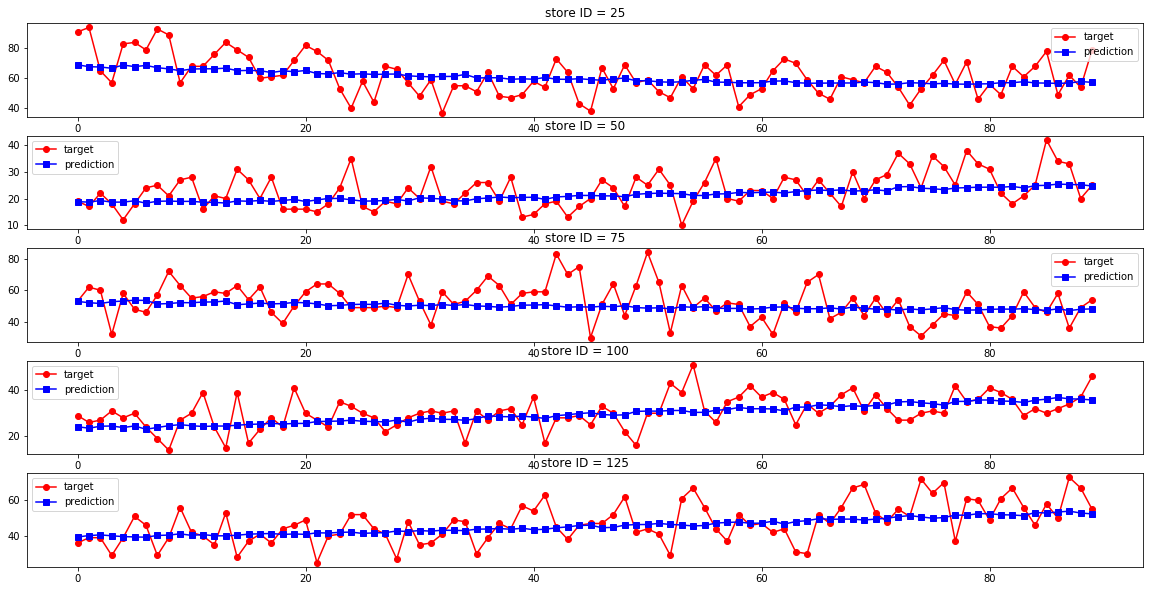

In [0]:
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(20, 10))
stidx=0
for i, ax in enumerate(axes.flatten()):
        stidx+=25
        ax.plot(y_val[stidx,:], 'ro-', label="target")
        ax.plot(val_pred[stidx], 'bs-', label="prediction")
        ax.set_title('store ID = {}'.format(stidx))
        ax.legend()

plt.show()

- 실제 데이터는 noise가 많은 데 비해, 예측값은 흔들리지 않음을 볼 수 있음. 딥러닝이 알아서 noise를 학습할수는 없을까? 전처리로 denoising을 해주는 것은 autoencoder 등으로 가능하다 들었는데..

- 그래도 평균값과 trend는 얼추 맞추는 것으로 보임

## Evaluation 
The kaggle challenge are evaluated on SMAPE between forecasts and actual values. SMAPE = 0 when the actual and predicted values are both 0.

- SMAPE (Symmetric mean absolute percentage error)
https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
- smape_fast function ; https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/37232

kaggle에서 testset 정답을 다운받을수 없어, 우선 validation error만 봄. (validation set으로 early stopping했기 때문에 이 값으로 performance estimation하기는 힘듬. 참고만 할 것)

In [0]:
from numba import jit
import math

def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

In [0]:
stidx=10
smape_fast(y_val[stidx,:], val_pred[stidx])

17.04063281171125

In [0]:
y_val.shape

(640, 90)

In [0]:
eval_smape = lambda stidx: smape_fast(y_val[stidx,:], val_pred[stidx])

In [0]:
from scipy import stats
stats.describe(list(map(eval_smape,range(len(y_val)))))

DescribeResult(nobs=640, minmax=(12.129910767338211, 32.87474156416939), mean=18.221041735889475, variance=12.348330805193628, skewness=1.1408113585875204, kurtosis=1.574685354440744)

### TO DO & Limitation

- 보유하고 있는 17년 데이터를 testset으로 다시 evaluation하기!
- Scaling
- Denosing
- Sampling 분포 확인 (훈련/검증에 사용한 store, item 개수 다른지, 랜덤하게 잘 뽑혔는지)
- Plotting learning curve
- model 저장 추가
- ARIMA, Prophet과 LSTM 차이 공부할 것

- store, item 종류 정보도 같이 학습시키면 성능이 오를 것 같음. LSTM이 훈련을 위해 넣어준 값의 패턴 (X_train, X_val)을 보고 알아서 학습하길 바랬는데.. 

    이 데이터는 단순한 데이터라 어느정도 잘 예측했지만, 실제 데이터면 시점도 factor(feature)로 넣어 줘야 할듯하다. 2017년에만 발생한 큰 event가 있을 수도 있고, 한 store만 적용되는 event가 있을 수도 있으니. 상관관계 높은 item들이 있을 수도 있음. 
    input sequence 맨앞에 store, item을 붙여주면 될까? 좀더 시계열 분석 학습이 필요하다!

- Packed sequence를 쓰면 input length를 안맞춰줘도 되는데, 성능이 더 높아질지는 모르겠다. 그리고 pytorch엔 있는데 keras에도 있는지 모르겠음.